In [1]:
from sys import path
path.append('../../')
from kooplearn.kernels import RBF, Matern, Kernel
from kooplearn.estimators import ReducedRank, PrincipalComponent, KernelRidge 

from logistic_map_utils import LogisticMap, CosineKernel

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def only_upper(s):
    upper_chars = ""
    for char in s:
        if char.isupper():
            upper_chars += char
    return upper_chars

In [2]:
N = 100
logistic = LogisticMap(N=N)

Init: Transfer matrix: 100%|██████████| 101/101 [00:20<00:00,  4.86it/s]


### Prediction

In [5]:
sample_size = 2000
train_size = int(sample_size * 0.98)
x, y = logistic.sample(size=sample_size, iid=False)

x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

kernel = RBF(length_scale=0.5)
params = {
    'kernel': kernel,
    'backend': 'numpy',
    'rank': 3,
    'svd_solver': 'full',
    'n_oversamples': 10,
    'iterated_power': 3
}

params_KRR = {
    'kernel': kernel,
    'backend': 'numpy',
}

tikhonov_reg = 1e-5
predictions = {}
fitted_ests = {}
estimators = [ReducedRank, PrincipalComponent, KernelRidge]
for estimator_class in estimators:
    if estimator_class == ReducedRank:
        estimator = estimator_class(**params, tikhonov_reg = tikhonov_reg)
    elif estimator_class == KernelRidge:
        estimator = estimator_class(**params_KRR, tikhonov_reg = tikhonov_reg)
    else:
        estimator = estimator_class(**params)
    print(f"Fitting {estimator_class.__name__}")
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_test)
    predictions[only_upper(estimator_class.__name__) + 'R'] = y_pred
    fitted_ests[only_upper(estimator_class.__name__) + 'R'] = estimator

Fitting ReducedRank
Fitting PrincipalComponent
Fitting KernelRidge


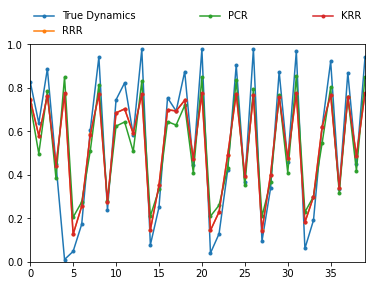

In [6]:
plt.plot(y_test, '.-', label='True Dynamics')
for name, y_pred in predictions.items():
    plt.plot(y_pred, '.-', label=name)
plt.margins(0.)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=3, frameon=False)

### Mode decomposition

In [4]:
kernels = {
    "Gaussian": RBF(length_scale = 0.5),
    "Matern 3/2": Matern(length_scale = 0.5, nu = 3/2),
    "Matern 5/2": Matern(length_scale = 0.5, nu = 5/2),
    "Cosine": CosineKernel(N=N),
}

params = {
    'backend': 'numpy',
    'rank': 3,
    'svd_solver': 'arnoldi',
    'tikhonov_reg': 1e-5,
    'n_oversamples': 10,
    'iterated_power': 3
}

num_repetitions = 100
sample_size = 1000
samples = np.zeros((2, sample_size, num_repetitions))
for idx in range(num_repetitions):
    x, y = logistic.sample(size=sample_size, iid=False)
    samples[0,:,idx] = x[:,0]
    samples[1,:,idx] = y[:,0]

estimated_evals = {}
for k_name in kernels.keys():
    estimator = ReducedRank(kernel=kernels[k_name],**params)
    _evls = []
    for idx in tqdm(range(num_repetitions)):
        x = samples[0,:,idx][:,None]
        y = samples[1,:,idx][:,None]
        estimator.fit(x, y)
        w = estimator.eig(right=False)
        _evls.append(w)
    estimated_evals[k_name] = np.asarray(_evls)

100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


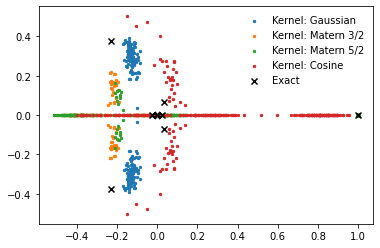

In [5]:
for k_name in kernels:
    plt.scatter(estimated_evals[k_name].real, estimated_evals[k_name].imag, label=f"Kernel: {k_name}", marker='o', s=5.5, alpha=1)
plt.scatter(logistic._evals.real, logistic._evals.imag, label="Exact", c='k', marker='x')
plt.legend(frameon=False)

In [6]:
kernel = RBF(length_scale = 0.5)
params = {
    'kernel': kernel,
    'rank': 3,
    'backend': 'numpy',
    'svd_solver': 'arnoldi',
    'n_oversamples': 10,
    'iterated_power': 3
}
tikhonov_reg = 1e-5
num_repetitions = 100
sample_size = 1000
samples = np.zeros((2, sample_size, num_repetitions))
for idx in range(num_repetitions):
    x, y = logistic.sample(size=sample_size, iid=False)
    samples[0,:,idx] = x[:,0]
    samples[1,:,idx] = y[:,0]

estimated_evals = {}
estimators = [ReducedRankRegression, PrincipalComponentRegression]
for estimator_class in estimators:
    if estimator_class == ReducedRankRegression:
        estimator = estimator_class(**params, tikhonov_reg = tikhonov_reg)
    else:
        estimator = estimator_class(**params)
    _evls = []
    for idx in tqdm(range(num_repetitions)):
        x = samples[0,:,idx][:,None]
        y = samples[1,:,idx][:,None]
        estimator.fit(x, y)
        w = estimator.eig(right=False)
        _evls.append(w)
    estimated_evals[only_upper(estimator_class.__name__)] = np.asarray(_evls)

100%|██████████| 100/100 [00:01<00:00, 69.61it/s]


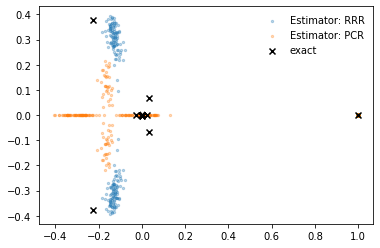

In [7]:
for est_name in estimated_evals.keys():
    plt.scatter(estimated_evals[est_name].real, estimated_evals[est_name].imag, label=f"Estimator: {est_name}", marker='o', s=5.5, alpha=0.3)
plt.scatter(logistic._evals.real, logistic._evals.imag, label="exact", c='k', marker='x')
plt.legend(frameon=False)